In [2]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import copy
from ctwr_model import *
from setup_plot import *

# Load experimental data
with open('mistral_exp_3p5.json', 'r') as f:
    mistral = json.load(f)

# 2D plot of water content
mod_res = {}


Patm = 1.01e5
P_list = np.linspace(0.85*Patm, 1.15*Patm, 20, endpoint=True)
T_list = np.linspace(5,35, 20, endpoint=True)
xrel_list = np.linspace(0.05,0.9, 20, endpoint=True)
Qa_m = [mistral[e]['Qa_kg/s'] for e in mistral]
Qa_list = np.linspace(60, 250, 20, endpoint=True)

print(np.average([mistral[e]['Tin_w_degC'] for e in mistral]))

T, Xr = np.meshgrid(T_list,xrel_list)

mw_liq = np.zeros_like(T)

Qd = 34538

def Qliq_out(t_val, xr_val):
    Patm = 1.01e5
    nc = 100
    
    # MISTRAL parameters
#     Qliq = 150
#     Qd = 150
#     Tw_i = 36.5 + 273.15

#     h_pack = 1.75
#     h_cold = 10
#     h_hot = 0.950
#     S_pack = 49

#     lam_ev = 0.75
#     n_ev = 0.6016
    
    # Dampierre parameters
    Qliq = 34538
    Qd = 1.229 * Qliq
    Tw_i = 34.7 + 273.15

    h_pack = 2
    h_hot = 950e-3                                                 
    h_cold = 11.34     
    S_pack = 11565
    
    lam_ev = 0.872
    n_ev = 0.6
    
    res = solve_ctwr(h_cold, h_pack, h_hot, S_pack, 
                     Patm, t_val, Tw_i, Qd, Qliq, 
                     xr_val, lamb_evap=lam_ev, n_evap=n_ev,
                     n_cells = nc)
    return res

mw_list = np.zeros_like(T)
icase = 0
print(T.shape[0], T.shape[1])
for i in range(T.shape[0]):
    for j in range(Xr.shape[1]):
        icase += 1
        tw_i = T[i,j] + 273.15
        xr_i = Xr[i,j]
        print(icase)
        ctwr_sol = Qliq_out(tw_i, xr_i)
        x_sol = ctwr_sol['x']
        xsat_sol = ctwr_sol['x_sat']
        if x_sol[-1] < xsat_sol[-1]:
            mw_list[i,j] = 0
        else:
            mw_list[i,j] = Qd * (x_sol[-1] - xsat_sol[-1])

            
# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the heatmap
cmap = ax.pcolormesh(T, Xr, mw_list, shading='auto', cmap='Blues')

# Add a colorbar *linked* to the same axis
cbar = fig.colorbar(cmap, ax=ax)
cbar.set_label(r'$\dot{m}_{liq}$')

# Labels and title
ax.set_xlabel(r'$T_{in}$ [°C]')
ax.set_ylabel(r'$x_{rel}$ [-]')

plt.tight_layout()
plt.show()

36.583636363636366
20 20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 

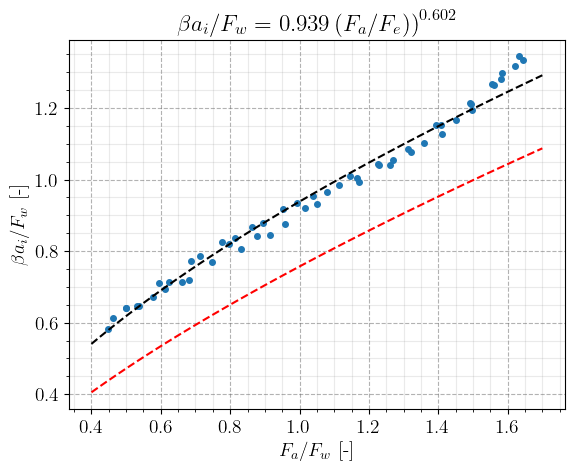

In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import copy
from ctwr_model import *
from setup_plot import *

# Load experimental data
with open('mistral_exp_3p5.json', 'r') as f:
    mistral = json.load(f)
Cf = [mistral[e]['Cf_pack'] for e in mistral]
Qa = [mistral[e]['Qa_kg/s'] for e in mistral]
Va = [mistral[e]['Va_m/s'] for e in mistral]

fig, ax1 = plt.subplots()
setup_ax(ax1, xlabel=r'$F_a/F_w$ [-]', ylabel=r'$\beta a_i / F_w$ [-]')

z_pack = 1.890

Fa_s_Fe = np.array([mistral[e]['Fa/Fe'] for e in mistral])

Me = np.array([mistral[e]['Me_9'] for e in mistral])
beta_a_s_Fe = [m/z_pack for m in Me]

ax1.scatter(Fa_s_Fe, beta_a_s_Fe)


res = np.polyfit(np.log(Fa_s_Fe), np.log(beta_a_s_Fe), deg=1)
fit = np.poly1d(res)
(lamfit, nfit) = (np.exp(fit[0]), fit[1])
flist = np.linspace(0.4,1.7,100)
ax1.plot(flist, [lamfit*(f**nfit) for f in flist], '--k')
ax1.plot(flist, [0.7572*(f**0.6818) for f in flist], '--r')

nval = round(nfit,3)
lamval = round(lamfit, 3)
ax1.set_title(fr'$\beta a_i / F_w = {lamval}\left(F_a/F_e)\right)^{{{nval}}}$')
plt.savefig('correl_evap.pdf', format='pdf')